<a href="https://colab.research.google.com/github/olithin/AddressBookUI/blob/master/module_2/grade_performance_school.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA
Exploratory Data Analysis - Анализ данных На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками. 



**Суть проекта** — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам. 
Миссия состоит в повышении уровня благополучия детей по всему миру.


Анализ признаков
Строим графики
Проводим корреляционный анализ
Находим дублирующиеся признаки
Находим выбросы
Cмотрим распределение целевой переменной
Распределение целевой переменной относительно признаков
Находим Возможные закономерности и взаимосвязи



In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

from itertools import combinations
from scipy.stats import norm
import missingno as msno
import plotly.express as px


%matplotlib inline  
from IPython.display import Markdown

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/olithin/DataScienceProjects/master/TestData/stud_math.csv')

In [ ]:
def get_stat_dif(column):          # Student's t-test
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):
            print('Найдены статистически значимые различия для колонки', column)
            break



# Границы выбросов
def get_outliners(column):
    median = df[column].median()
    quan25 = df[column].quantile(0.25)
    quan75 = df[column].quantile(0.75)
    IQR = quan75 - quan25
    left = quan25 - 1.5*IQR,
    right = quan75 + 1.5*IQR
    print(f"Границы выбросов для столбца '{column}': [{left}, {right}]")

## **1. Data Preprocessing**

Данные не всегда представляют собой идеально организованный набор наблюдений без каких-либо пропусков или аномалий Обычно данные содержат в себе кучу мусора, который необходимо почистить. Чистка данных — это необходимый этап решения почти любой задачи.

1. Пропущенные значения в данных
2. Неструктурированные, разбросанные данные
3. Недостаток информации

#### Анализ признаков:
1. Строим графики

2. Находим дублирующиеся признаки
3. Находим выбросы
4. Cмотрим распределение целевой переменной
5. Распределение целевой переменной относительно признаков
6. Находим Возможные закономерности и взаимосвязи
7. Проводим корреляционный анализ

[A detailed Check list for data pre-processing](https://towardsdatascience.com/a-checklist-for-data-pre-processing-before-you-build-your-machine-learning-model-91d2d04dc53f)

#### **1.0 Determine the number of rows in dataframe**

In [8]:
df.shape  

(395, 30)

🤔 The data contains 395 rows and 30 colunmns.

In [37]:
df.head(10)
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   Pstatus             350 non-null    object 
 6   Medu                392 non-null    float64
 7   Fedu                371 non-null    float64
 8   Mjob                376 non-null    object 
 9   Fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

1.0 What kind of data is represented in each column ?

In [9]:
df.dtypes    # Displays all the data types of the columns in df         

school                  object
sex                     object
age                      int64
address                 object
famsize                 object
Pstatus                 object
Medu                   float64
Fedu                   float64
Mjob                    object
Fjob                    object
reason                  object
guardian                object
traveltime             float64
studytime              float64
failures               float64
schoolsup               object
famsup                  object
paid                    object
activities              object
nursery                 object
studytime, granular    float64
higher                  object
internet                object
romantic                object
famrel                 float64
freetime               float64
goout                  float64
health                 float64
absences               float64
score                  float64
dtype: object

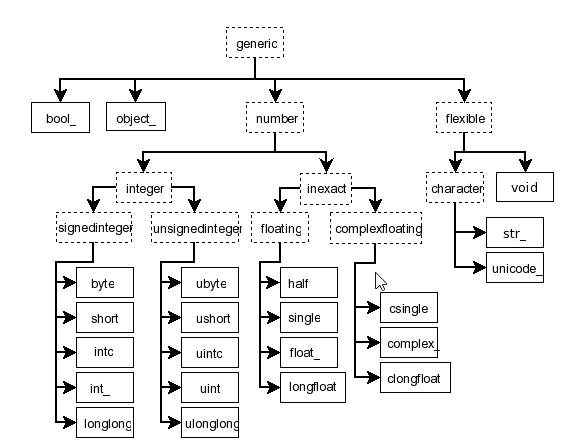

🤔 Questions to investigate:
1. Are there categorical columns that should be numeric ( or vice-versa) ?
2. Are all the columns rightly classified as the right data type? If not, change the data types.

eg: ZIP codes are generally classified as numeric, but, they are indeed categorical. Are they parsed by pandas as the right data type ?
eg: Are Date types classified correctly — or are they represented as ‘object’

**TIP 1**: To see the description of the data, ( not just for continuous variables, use the include = 'all’ parameter . This includes the other functions like unique , top and freq to your categorical variables.

**TIP #2** :If you have lots of columns, using a Transpose function on the dataframe .T will help you view it in one page ( one below the other — and not horizontally — which might get truncate the number of columns shown, based on your jupyter notebook settings )
df.describe(include='all').T

**TIP #3**: If you want to select only the categorical columns , use the select_dtypes function
cat_cols = df.select_dtypes(include=[“object”, “category”]).columns.tolist()

**TIP #4** : To select numeric columns only ,
num_cols = df.select_dtypes(include=[“number”]).columns.tolist()

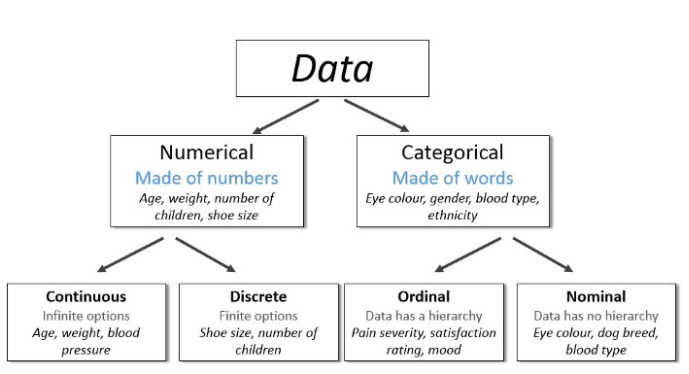

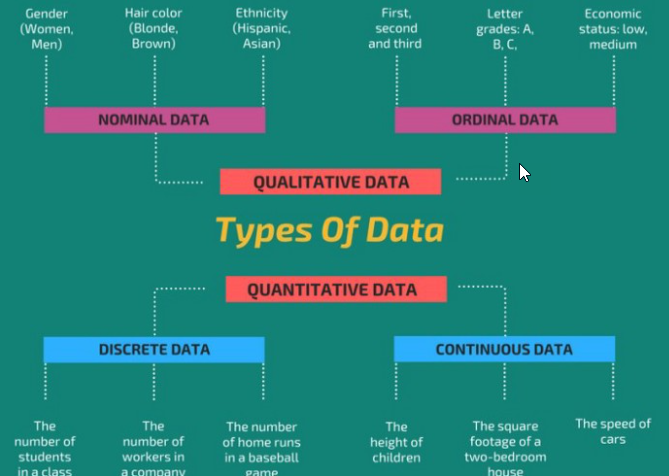

In [11]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
school,395,2,GP,349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,395,2,F,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,395,NaN,NaN,NaN,16.6962,1.27604,15,16,17,18,22
address,378,2,U,295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsize,368,2,GT3,261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pstatus,350,2,T,314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medu,392,NaN,NaN,NaN,2.75,1.09813,0,2,3,4,4
Fedu,371,NaN,NaN,NaN,2.61456,2.22873,0,2,2,3,40
Mjob,376,5,other,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fjob,359,5,other,197,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [70]:
num = df.select_dtypes(include=['number']).columns.tolist()
num

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'studytime_granular',
 'famrel',
 'freetime',
 'goout',
 'health',
 'absences',
 'score']

🤔  Short summary of the dataframe:

As we can see in the output, the summary includes list of all columns with their data types and the number of non-null values in each column. 

Types: 

* 1 integer type column, 12 types- float64 and 17 object types.

The 'object' data type is 
'a catch-all for columns that Pandas doesn’t recognize as any other specific type.' 

In practice, it often means that all of the values in the column with type 'object' are strings.
 
* Also, all the columns do not have 395 values which indicates that there are missing values.


In [79]:
for x in cat_cols:
   print(f'{x} ==> {df[x].unique()}\n{df[x].value_counts()}')

school ==> ['GP' 'MS']
GP    349
MS     46
Name: school, dtype: int64
sex ==> ['F' 'M']
F    208
M    187
Name: sex, dtype: int64
address ==> ['U' nan 'R']
U    295
R     83
Name: address, dtype: int64
famsize ==> [nan 'GT3' 'LE3']
GT3    261
LE3    107
Name: famsize, dtype: int64
Pstatus ==> ['A' nan 'T']
T    314
A     36
Name: Pstatus, dtype: int64
Mjob ==> ['at_home' 'health' 'other' 'services' 'teacher' nan]
other       133
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64
Fjob ==> ['teacher' 'other' nan 'health' 'services' 'at_home']
other       197
services    102
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64
reason ==> ['course' 'other' 'home' 'reputation' nan]
course        137
home          104
reputation    103
other          34
Name: reason, dtype: int64
guardian ==> ['mother' 'father' 'other' nan]
mother    250
father     86
other      28
Name: guardian, dtype: int64
schoolsup ==> ['yes' 'no' nan]
no     335

In [80]:
for x in num:
   print(f'{x} ==> {df[x].unique()}\n{df[x].value_counts()}')  # we should modify  'studytime, granular' column before executing due to an error in result

age ==> [18 17 15 16 19 22 20 21]
16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64
Medu ==> [ 4.  1.  3.  2. nan  0.]
4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64
Fedu ==> [ 4.  1.  2.  3. 40. nan  0.]
2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64
traveltime ==> [ 2.  1.  3. nan  4.]
1.0    242
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64
studytime ==> [ 2.  3.  1. nan  4.]
2.0    194
1.0    103
3.0     64
4.0     27
Name: studytime, dtype: int64
failures ==> [ 0.  3. nan  2.  1.]
0.0    293
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64
studytime_granular ==> [ -6.  -9.  -3.  nan -12.]
-6.0     194
-3.0     103
-9.0      64
-12.0     27
Name: studytime_granular, dtype: int64
famrel ==> [ 4.  5.  3. nan -1.  2.  1.]
 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64


🤔  KeyError Exception for column 'studytime, granular'. We should investigate this column



#### 🤔  Data types description notes:


**Categorical -Qualitative:**

>['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

*  8 Nominal data:  school, sex, address, famsize, Pstatus, Mjob, Fjob, reason

* 9 Binary data: guardian, schoolsup,famsup, paid, activities, nursery, higher, internet, romantic


**Categorical -Quantitative:**

> ['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'studytime_granular',
 'famrel',
 'freetime',
 'goout',
 'health',
 'absences',
 'score']

* 2 Numerical -continuous : score, age
* 11 Numerical - discret: absences, 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'studytime_granular', 'famrel', 'freetime', 'goout', 'health', 

> Note: we should check via info if types is correct (example: age should not have float64 type)

#### **1.2 Showing Basics Statistics**

In [ ]:
df.describe() # Чтобы узнать разброс значений, среднюю арифм и медиану, используем метод .describe():
              #Этот метод используется для получения сводки числовых значений в вашем наборе данных Он вычисляет среднее значение,
              # стандартное отклонение, минимальное значение, максимальное значение, 1-й процентиль, 2-й процентиль, 3-й процентиль 
              #столбцов с числовыми значениями. Он также подсчитывает количество переменных в наборе данных.

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


🤔 A first look notes:

 The describe() method provides a quick overview of the numerical data in a DataFrame. 

We see that age column has expected interval of ages max -22 ages, min -15 ages. So the data has correct values according our task. 

But usually, Secondary school students are  15 to 19 years old and I would suggest **dropping the data for 20-22 years old** students due to the inconsistent result in compromisation (they could not have the same category in statistics) **or creating one more Category** to separate the data and conclusion. 

Columns like Mjob and Fjob are textual data, these are **by default** not taken into account by the describe() method. But is possible with an option '(include=["object"])'. Example in following row of current notebook.

**Risk group of students is under 50th percentile** with score 55/100



In [43]:
df.groupby('school').agg(['count', 'size', 'nunique']).stack()

sex  age  address  famsize  ...  goout  health  absences  score
school                                      ...                                
GP     count    349  349      337      324  ...    341     334       338    344
       size     349  349      349      349  ...    349     349       349    349
       nunique    2    7        2        2  ...      5       5        34     18
MS     count     46   46       41       44  ...     46      46        45     45
       size      46   46       46       46  ...     46      46        46     46
       nunique    2    5        2        2  ...      5       5        11     14

[6 rows x 29 columns]

In [30]:
df.describe(include=["object"]) 

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,378,368,350,376,359,378,364,386,356,355,381,379,375,361,364
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,295,261,314,133,197,137,250,335,219,200,195,300,356,305,240


🤔 A first look notes: 

the dataset contains 395 students, most of the girls from 'GP' school with high-level courses, without additional support from the school, without extra paid math lessons from family lives in town with status -T(parents lived together) with family size >3, nursery passed, willing to receive a university education, participating in different activities out of the school and they are not in a relationship (romantic).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0d08c1250>,
      dtype=object)

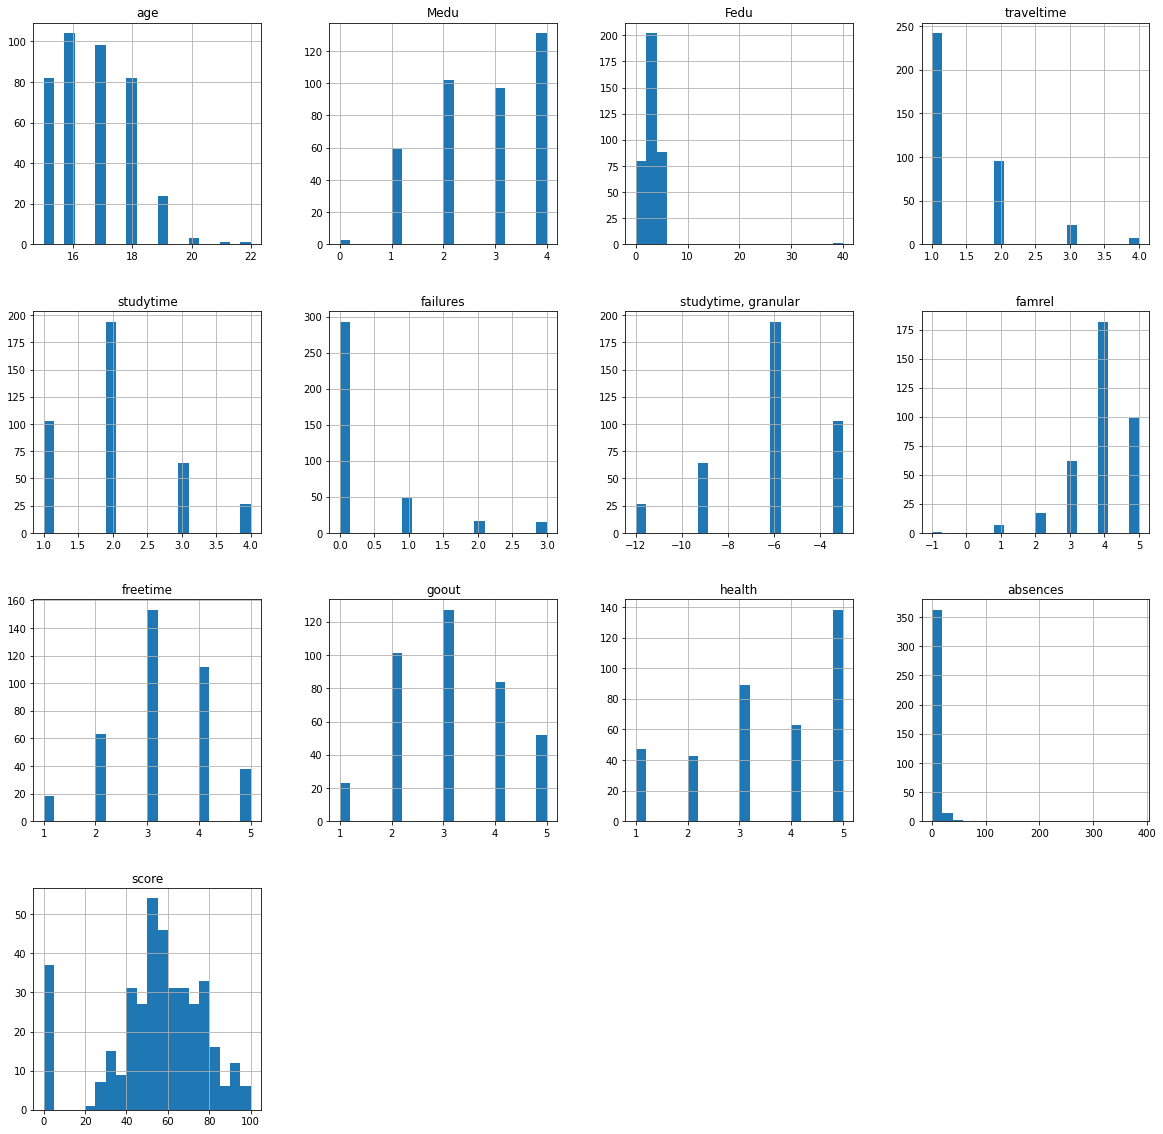

In [ ]:
df.hist(figsize=(20, 20), bins=20)

#### Considering data with min and max score value

In [ ]:
df.max()

school                  MS
sex                      M
age                     22
Medu                     4
Fedu                    40
traveltime               4
studytime                4
failures                 3
studytime, granular     -3
famrel                   5
freetime                 5
goout                    5
health                   5
absences               385
score                  100
dtype: object

In [ ]:
df.min()

school                 GP
sex                     F
age                    15
Medu                    0
Fedu                    0
traveltime              1
studytime               1
failures                0
studytime, granular   -12
famrel                 -1
freetime                1
goout                   1
health                  1
absences                0
score                   0
dtype: object

In [ ]:
df.query('score==100 | score==20')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
47,GP,2,16,U,GT3,T,4.0,3.0,health,NaN,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0
216,GP,1,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0


🤔 First look notes. 
The difference between max (100) and min(20) score is showing us :

* Column '**absences**' influence the result - 22 missed lectures leads to the bad grade

* Category '**health**' seems the same - bad health
* Category '**goout**' influence the result - spending too much time with friends leads to the bad grade
* Category '**romantic**' influence the result - students in reletionship has bad grade
* Category '**paid**'- even paid math lessons sometimes doesn't help to be successful at school
* Category '**activities**' - if student has no activities out of school it's also leads to the bad grade





In [36]:
df[df == 0].count()   # Check for zeros in all columns 

school                  0
sex                     0
age                     0
address                 0
famsize                 0
Pstatus                 0
Medu                    3
Fedu                    2
Mjob                    0
Fjob                    0
reason                  0
guardian                0
traveltime              0
studytime               0
failures              293
schoolsup               0
famsup                  0
paid                    0
activities              0
nursery                 0
studytime_granular      0
higher                  0
internet                0
romantic                0
famrel                  0
freetime                0
goout                   0
health                  0
absences              111
score                  37
dtype: int64

#### 2.0 **Preparing our data-set — Check Columns Names**

In [57]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [ ]:
df.columns = df.columns.str.lower()  # column name to low case

In [61]:
df.columns =[col.replace(' ','_') for col in df.columns] #replacing spaces in column names with '_'
df.columns =[col.replace(',','') for col in df.columns] #replacing comma in column names with empty value

df.head(1)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0


## 1.4 **Outlier detection**
В ящиках с усами выбросы определяются по формуле межквартильного размаха.

Можно написать цикл по всем числовым столбцам.

In [ ]:
for column in df.select_dtypes(include = [np.number]).columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)
    print(column)
    display(df[~df[column].between(lower_bound, upper_bound, inclusive=True)])

🤔 Dataset has many outliers values, so we have to analyze all data.

***Some techniques:***

a. Dropping the outliers data.

b. Caping the outliers data: You replace the outliers values with upper bound and lower bound. outliers that are located at more upper bound be replaced by upper bound values. Otherwise, outliers that are located at more the lower bound can be replaced with lower bound.

c. Replacing with new values: You replace outliers value with mean, median, or mode.

Для того чтобы понять, как правильно обработать пропуски, в идеале нужно определить механизмы их формирования. Пропуски могут быть распределены в данных случайно, а могут – не случайно. https://towardsdatascience.com/statistical-test-for-mcar-in-python-9fb617a76eac

**MCAR** — механизм формирования пропусков, при котором вероятность пропуска для каждого наблюдения одинакова. В таком случае игнорирование/исключение записей, содержащих пропущенные данные, не ведет к искажению результатов. Замена допустима.

**MAR**— на практике данные обычно пропущены не случайно, а ввиду некоторых закономерностей (если вероятность пропуска может быть определена на основе другой имеющейся в наборе данных информации, не содержащей пропуски). В таком случае удаление или правильная замена пропусков также не приведет к существенному искажению результатов.

**MNAR** — механизм формирования пропусков, при котором данные отсутствуют в зависимости от неизвестных факторов. MNAR предполагает, что вероятность пропуска могла бы быть описана на основе других атрибутов, но информация по этим атрибутам в наборе данных отсутствует. В таком случае любые манипуляции с пропусками могут привести к существенному искажении выводов.

## **1.5 Missing values** :


> Handling missing values:


*   Standard values like “Not Available” or “NA” can be used to replace the missing values.
*   Missing values can also be filled manually but it is not recommended when that dataset is big.
*   The attribute’s mean value can be used to replace the missing value when the data is normally distributed
wherein in the case of non-normal distribution median value of the attribute can be used.
*   While using regression or decision tree algorithms the missing value can be replaced by the most probable
value. 






Text(0.5, 1.0, 'Missing values heatmap')

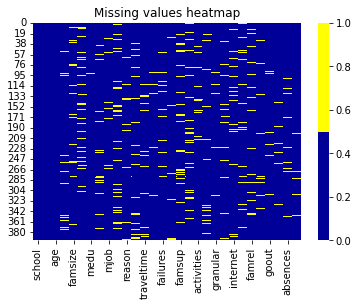

In [ ]:
colours = ['#000099', '#ffff00']  # желтый - пропущенные данные, синий - не пропущенные
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours) ).set_title("Missing values heatmap")  

In [ ]:
(df.isna().mean()*100).round(2)  # the percentage of null values

school                  0.00
sex                     0.00
age                     0.00
address                 4.30
famsize                 6.84
Pstatus                11.39
Medu                    0.76
Fedu                    6.08
Mjob                    4.81
Fjob                    9.11
reason                  4.30
guardian                7.85
traveltime              7.09
studytime               1.77
failures                5.57
schoolsup               2.28
famsup                  9.87
paid                   10.13
activities              3.54
nursery                 4.05
studytime, granular     1.77
higher                  5.06
internet                8.61
romantic                7.85
famrel                  6.84
freetime                2.78
goout                   2.03
health                  3.80
absences                3.04
score                   1.52
dtype: float64

🤔 Column School, Sex, Age have no missing value

General Recommendations from experts: delete missing value if the column consist more then 30% -40% missing values.

So, we will try to replace our missing values due to the max missing value is - 11% in each column


In [ ]:
null_df = df.isnull().sum()   # missing value count. We can use .isnull followed by a .sum and get the number of missing values.
null_df[null_df>0]

address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

In [ ]:
df.nunique()  # check number of unique values

school                  2
sex                     2
age                     8
address                 2
famsize                 2
Pstatus                 2
Medu                    5
Fedu                    6
Mjob                    5
Fjob                    5
reason                  4
guardian                3
traveltime              4
studytime               4
failures                4
schoolsup               2
famsup                  2
paid                    2
activities              2
nursery                 2
studytime, granular     4
higher                  2
internet                2
romantic                2
famrel                  6
freetime                5
goout                   5
health                  5
absences               36
score                  18
dtype: int64

#### **1.3 Finding and removing duplicate rows if exist**

In [ ]:
df.duplicated().sum()

0

🤔 No dublicates were found

sex  age  address  famsize  ...  goout  health  absences  score
school                                      ...                                
GP     count    349  349      337      324  ...    341     334       338    344
       size     349  349      349      349  ...    349     349       349    349
       nunique    2    7        2        2  ...      5       5        34     18
MS     count     46   46       41       44  ...     46      46        45     45
       size      46   46       46       46  ...     46      46        46     46
       nunique    2    5        2        2  ...      5       5        11     14

[6 rows x 29 columns]

🤔 349 students from 'GP' school and 46 is from 'MS'

## **2.0 A Closer Look At Dataset Columns**
 **Column Score** - Target Variable

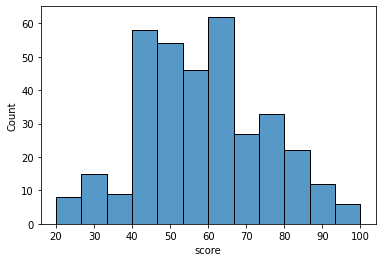

In [ ]:
sns.histplot(df.score)

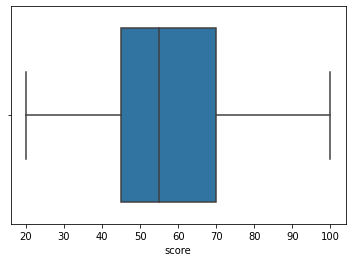

In [ ]:
sns.boxplot(x=df.score)

In [ ]:
df = df.query("score not in [0, 'NaN']")
df.score.describe()

count    352.000000
mean      57.755682
std       16.200928
min       20.000000
25%       45.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

🤔 NaN and '0' value deleted due to the not necessary data for the total design.

In [ ]:
df['score'].value_counts().sort_index()  # amount of students for each mark

20.0      1
25.0      7
30.0     15
35.0      9
40.0     31
45.0     27
50.0     54
55.0     46
60.0     31
65.0     31
70.0     27
75.0     33
80.0     16
85.0      6
90.0     12
95.0      5
100.0     1
Name: score, dtype: int64

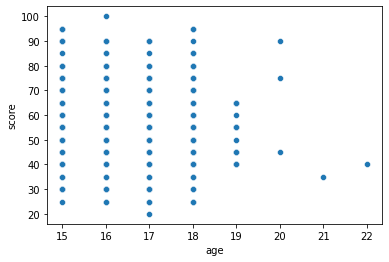

In [ ]:
sns.scatterplot(x='age',
                y='score',
                data=df);  # видно распределение данных в категории age относительно score 

##Column Age

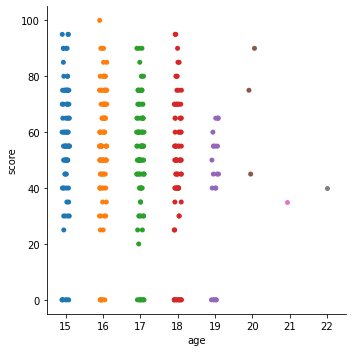

In [ ]:
sns.catplot(x='age',
                y='score',
                data=df);  # влияние возраста на оценки

🤔 Outliers were detected for students 20 to 22 years old. I consider this data is inconsistent due to the regular ages in school is  till 19 years old

In [ ]:
df = df.query('age<=19')

In [ ]:
df.describe() # check the data is modified

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,347.000000,345.000000,326.000000,324.000000,340.000000,327.000000,340.000000,323.000000,339.000000,341.000000,334.000000,337.000000,347.000000
mean,16.576369,2.814493,2.674847,1.432099,2.052941,0.244648,-6.158824,3.925697,3.215339,3.079179,3.520958,7.513353,57.766571
std,1.166396,1.091893,2.337345,0.693861,0.839734,0.622749,2.519203,0.919453,0.995969,1.093917,1.413527,22.244327,16.109640
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,20.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,2.000000,47.500000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,17.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,19.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


### Column sex

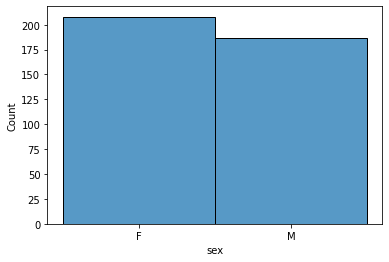

In [ ]:
sns.histplot(df['sex'])


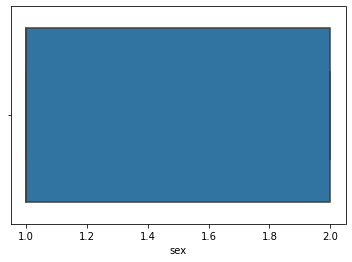

In [ ]:
df.sex = df.sex.apply(lambda x: 1 if 'F' in x else 2)
sns.boxplot(x=df['sex'])

In [ ]:
df.groupby(['address','score'])['address'].count()

address  score
R        0.0      10
         25.0      4
         30.0      3
         35.0      6
         40.0      6
         45.0      3
         50.0     17
         55.0      9
         60.0      6
         65.0      7
         70.0      3
         75.0      2
         80.0      3
         85.0      1
         90.0      2
         95.0      1
U        0.0      26
         20.0      1
         25.0      3
         30.0     11
         35.0      3
         40.0     25
         45.0     24
         50.0     35
         55.0     34
         60.0     22
         65.0     23
         70.0     24
         75.0     28
         80.0     12
         85.0      5
         90.0     10
         95.0      4
         100.0     1
Name: address, dtype: int64

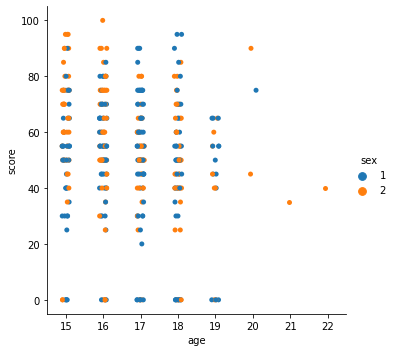

In [ ]:
sns.catplot(x='age',
                y='score',
                hue = 'sex',
                data=df);  # влияние пола студента и возраста на оценки

#### **Column address**

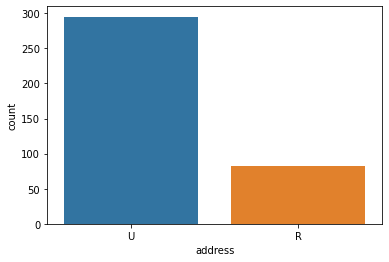

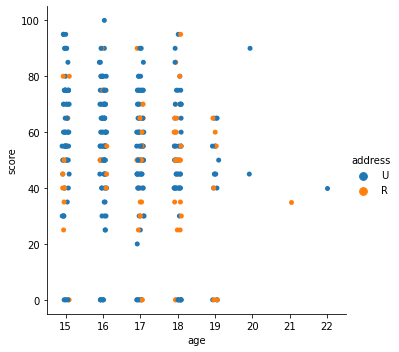

In [ ]:
sns.countplot(x='address', data=df)

sns.catplot(x='age',
                y='score',
                hue = 'address',
                data=df);  # влияние адреса студента и возраста на оценки

### Column School

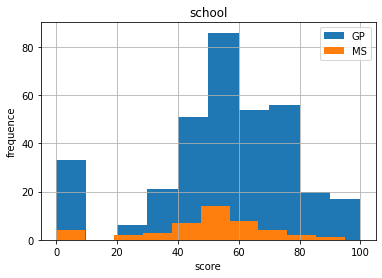

In [ ]:
# checking if different school influence  the score 

GP = df[df.school == 'GP'].score.copy()
MS = df[df.school == 'MS'].score.copy()
GP.hist(label='GP')
MS.hist(label='MS')
plt.xlabel('score', fontsize=10)
plt.ylabel('frequence', fontsize=10)
plt.title('school')
plt.grid(True)
plt.legend()
plt.show()

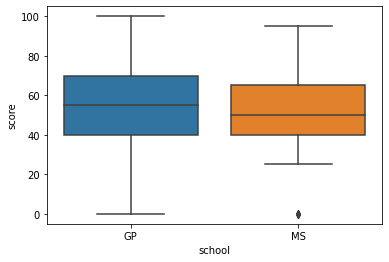

In [ ]:
sns.boxplot(x='school', y='score', data=df)

🤔  Распределение оценок в школах схожее.

Вероятно, колонку можно удалить. 

Но мы еще можем предположить, если студент тратит много времени на дорогу в школу, то это могло бы повлиять на оценки в худшую сторону. (меньше времени на выполнение домашнего задания, на дополнительные занятия, на отдых, на друзей и тд). 



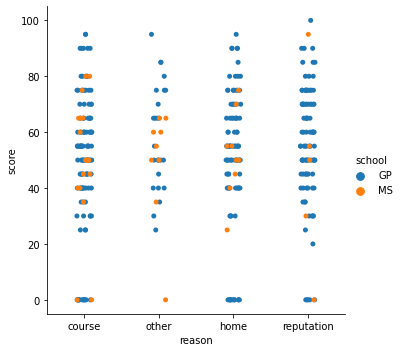

In [ ]:
sns.catplot(x='reason',
                y='score',
                hue = 'school',
                data=df); 

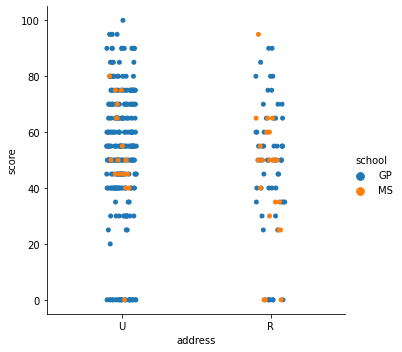

In [ ]:
sns.catplot(x='address',
                y='score',
                hue = 'school',
                data=df);  

Распределение по score равномерное, нет скоплений данных в определенном сегменте как для городских студентов, так и для живущих за городом.
Также сравнив оценки с колонкой 'reason', где опция 'home' (близость к дому) не выделилась на графике как признак хороших оценок (образовательные курсы и репутация школы сыграли большую роль), можно сказать, что наша гипотеза об ухудшении оценок в силу долгой дороги до школы не подтвердилась. 

Колонку school удаляем 

In [ ]:
df.drop('school', axis=1, inplace=True)

In [ ]:
df[df['address'].isnull()] # display all rows where 'address' is null

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
6,GP,2,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
52,GP,2,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,-3.0,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
75,GP,2,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
92,GP,1,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
96,GP,2,16,NaN,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,-3.0,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
159,GP,2,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
241,GP,2,17,NaN,LE3,A,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,3.0,3.0,NaN,4.0,2.0,60.0
254,GP,2,17,NaN,NaN,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0
292,GP,1,18,NaN,LE3,T,2.0,1.0,services,at_home,reputation,mother,1.0,2.0,1.0,no,NaN,no,no,yes,-6.0,yes,yes,yes,5.0,4.0,3.0,5.0,12.0,65.0
348,GP,1,17,NaN,GT3,T,4.0,3.0,health,other,reputation,mother,NaN,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,NaN,4.0,3.0,4.0,0.0,75.0


### Studytime, granular column

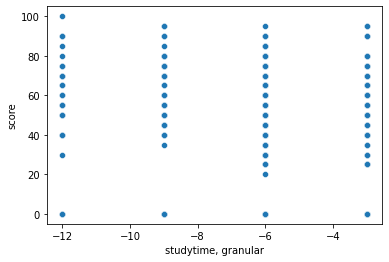

In [ ]:
sns.scatterplot(data = df, x='studytime, granular', y='score')

🤔 Column studytime in a dataset seems to me has a relationship between'Studytime, granular' column

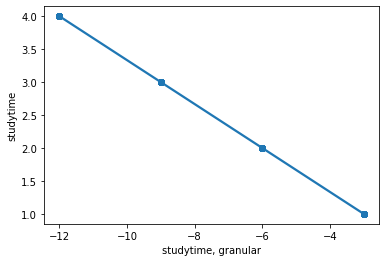

In [ ]:
sns.regplot(data = df, x='studytime, granular', y='studytime')
df = df.drop(columns = 'studytime, granular')

🤔 Categories  'studytime, granular' and 'studytime' are mutually exclusive.
We should drop the 'studytime, granular' column

### Correlation analyse

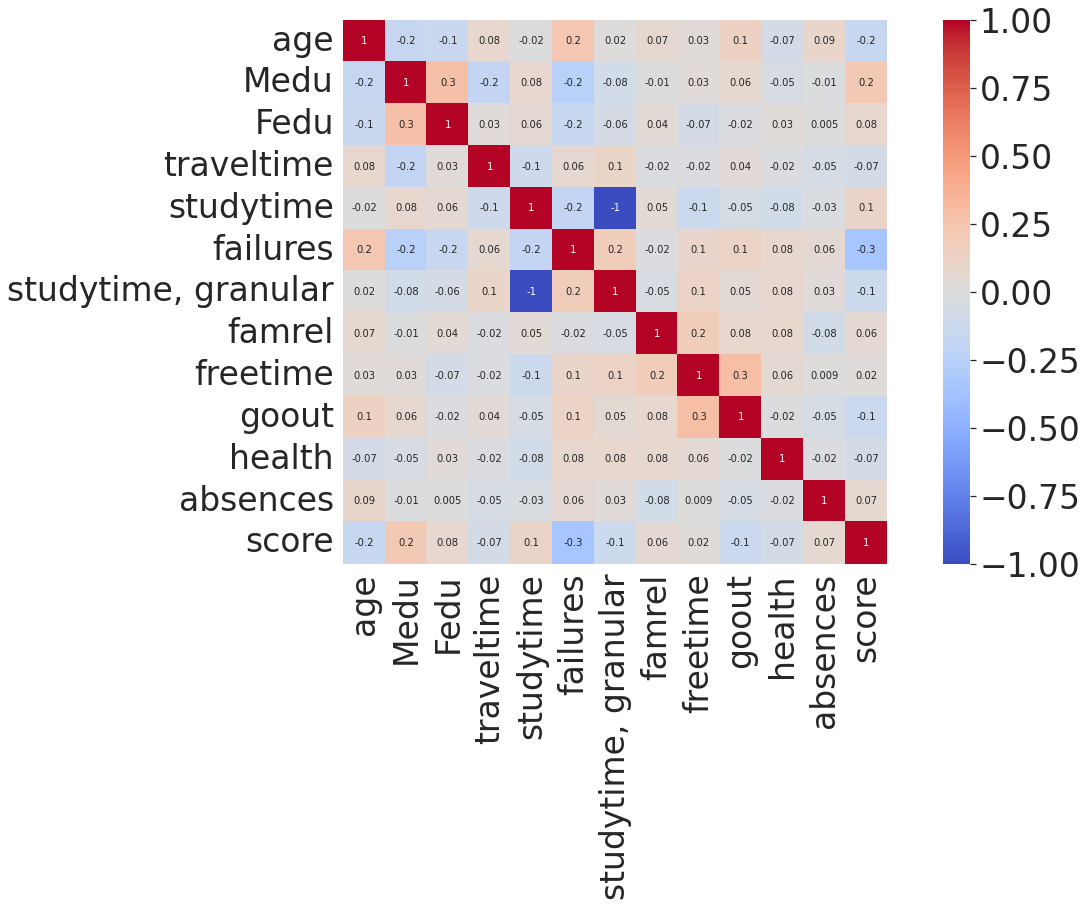

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 10})

sns.heatmap(
    df.corr(), 
    annot = True, 
    fmt ='.1g',
    square=True,
    cmap= 'coolwarm');

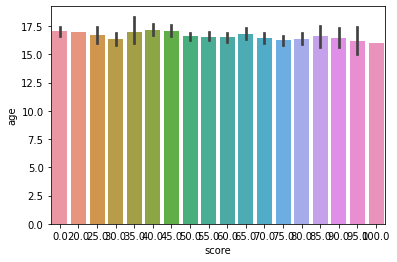

In [ ]:
sns.barplot(x="score", y="age", data=df);
plt.show()

### Как влияет здоровье и возраст ребенка на оценки

In [ ]:
pd.crosstab(index=df["score"], columns=df["age"], values=df['health'], aggfunc="mean")

####<font color='blue'>Conclusion: 
1) We can make some immediate interpretations about our dataframe:
Missing data tends to introduce bias that leads to misleading results so they cannot be ignored.
>- Column **School, Sex, Age** have no missing value

2) No dublicated values were found


####<font color='blue'>Prediction

romantic, absence